In [1]:
from torchvision.models import detection
import numpy as np
import argparse
import pickle
import torch
import cv2
import glob
import matplotlib.pyplot as plt

In [39]:
# params
args = {}
args["model"] = "frcnn-resnet" # "frcnn-mobilenet", "retinanet"
args["labels"] = "labels.txt"
args["confidence"] = 0.4

In [29]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open("labels.txt") as fin:
    data = fin.readlines()
    CLASSES = [d.strip() for d in data]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [30]:
print("Current device --------------------------------")
print(DEVICE)

Current device --------------------------------
cpu


In [31]:
print("COCO labels --------------------------------")
print(CLASSES)

COCO labels --------------------------------
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'tooth

In [32]:
MODELS = {
	"frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
	"frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
	"retinanet": detection.retinanet_resnet50_fpn
}
# load the model and set it to evaluation mode
model = MODELS[args["model"]](pretrained=True, progress=True, num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [33]:
# Load test images
files = glob.glob("images/*.jpg")
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in files]

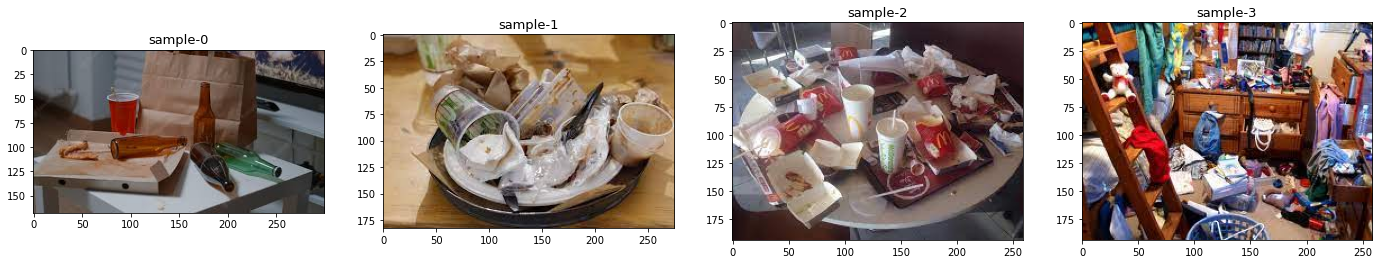

In [34]:
# display images
f, axes = plt.subplots(1, 4, figsize=(24, 4))
ax = axes.flatten()
    
for idx, img in enumerate(images):
    ax[idx].imshow(img)
    ax[idx].set_title('sample-{}'.format(idx), fontsize=13)

plt.show()

In [35]:
# perform object recognition
detections = []
for img in images:
    image = img.transpose((2, 0, 1))
    # add the batch dimension, scale the raw pixel intensities to the
    # range [0, 1], and convert the image to a floating point tensor
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    image = torch.FloatTensor(image)
    image = image.to(DEVICE)
    detections.append(model(image)[0])

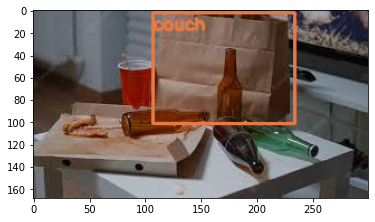

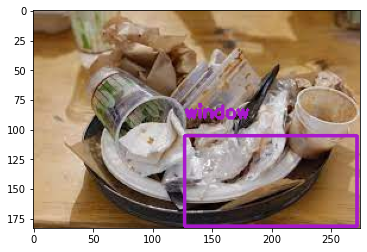

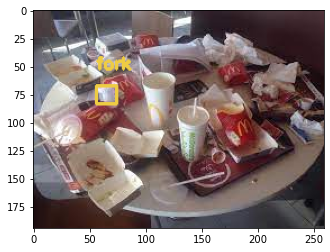

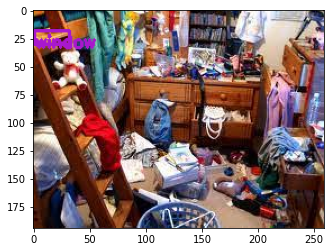

In [40]:
# loop over the detections
for jdx, d in enumerate(detections):
    for i in range(0, len(d["boxes"])):
        confidence = d["scores"][i]
        if confidence > args["confidence"]:
        # extract the index of the class label from the detections, then compute the (x, y)-coordinates of the bounding box
            idx = int(d["labels"][i])
            box = d["boxes"][i].detach().cpu().numpy()
            (startX, startY, endX, endY) = box.astype("int")
            #label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
            label = CLASSES[idx]
            image = np.copy(images[jdx])
            cv2.rectangle(image, (startX, startY), (endX, endY), COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
    #fig = plt.gcf()
    #fig.set_size_inches(10, 10)       
    plt.imshow(image)
    plt.show()